# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>attention</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

HW Writeup: On Piazza/Course Website <br>
Kaggle Competition Link: https://www.kaggle.com/competitions/11-785-s23-hw4p2/ <br>
Kaggle Dataset Link: https://www.kaggle.com/datasets/varunjain3/11-785-s23-hw4p2-dataset
<br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Read this section importantly!

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. You are allowed to use code from your previous homeworks for this homework. We will only provide, aspects that are necessary and new with this homework. 

3. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [1]:
!nvidia-smi

Sun Apr 30 21:45:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb kaggle pytorch-nlp 

# Imports

In [3]:
# Import Necessary Modules you require for this HW here

# Toy Dataset Download

In [4]:
# !wget -q https://cmu.box.com/shared/static/om4qpzd4tf1xo4h7230k4v1pbdyueghe --content-disposition --show-progress
# !unzip -q hw4p2_toy.zip -d ./

# Kaggle Dataset Download

In [5]:
# api_token = '{"username":"yunxingu","key":"b0d791b8d8e9237e047196d9e5f3c070"}'

# # set up kaggle.json
# # TODO: Use the same Kaggle code from HW1P2, HW2P2, HW3P2
# !mkdir /root/.kaggle/

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write(api_token) # Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json

In [6]:
# # To download the dataset
# !kaggle datasets download -d varunjain3/11-785-s23-hw4p2-dataset

In [7]:
# # To unzip data quickly and quietly
# !unzip -q 11-785-s23-hw4p2-dataset.zip -d ./data

# Dataset and Dataloaders

We have given you 2 datasets. One is a toy dataset, and the other is the standard LibriSpeech dataset. The toy dataset is to help you get your code implemented and tested and debugged easily, to verify that your attention diagonal is produced correctly. Note however that it's task (phonetic transcription) is drawn from HW3P2, it is meant to be familiar and help you understand how to transition from phonetic transcription to alphabet transcription, with a working attention module.

Please make sure you use the right constants in your code implementation for future modules, (SOS_TOKEN vs SOS_TOKEN_TOY) when working with either dataset. We have defined the constants accordingly below. Before you come to OH or post on piazza, make sure you aren't misuing the constants for either dataset in your code. 

## Toy Dataset

The toy dataset is a dataset of fixed length speech sequences that have phonetic transcripts. The reason we made it with phonetic transcripts was to help you understand how attention can work with phonetic transcription that you have done in HW3P2

In [8]:
# Load the toy dataset
import numpy as np
import torch
X_train = np.load("hw4p2_toy/f0176_mfccs_train_new.npy")
X_valid = np.load("hw4p2_toy/f0176_mfccs_dev_new.npy")
Y_train = np.load("hw4p2_toy/f0176_hw3p2_train.npy")
Y_valid = np.load("hw4p2_toy/f0176_hw3p2_dev.npy")

# This is how you actually need to find out the different trancripts in a dataset. 
# Can you think whats going on here? Why are we using a np.unique?
VOCAB_MAP_TOY           = dict(zip(np.unique(Y_valid), range(len(np.unique(Y_valid))))) 
VOCAB_MAP_TOY["[PAD]"]  = len(VOCAB_MAP_TOY)
VOCAB_TOY               = list(VOCAB_MAP_TOY.keys())

SOS_TOKEN_TOY = VOCAB_MAP_TOY["[SOS]"]
EOS_TOKEN_TOY = VOCAB_MAP_TOY["[EOS]"]
PAD_TOKEN_TOY = VOCAB_MAP_TOY["[PAD]"]

Y_train = [np.array([VOCAB_MAP_TOY[p] for p in seq]) for seq in Y_train]
Y_valid = [np.array([VOCAB_MAP_TOY[p] for p in seq]) for seq in Y_valid]

In [9]:
X_train.shape

(16000, 176, 27)

In [10]:
X_train[0].shape

(176, 27)

In [11]:
X_train[1].shape

(176, 27)

In [12]:
len(Y_train)

16000

In [13]:
class ToyDataset(torch.utils.data.Dataset):

    def __init__(self, partition):

        if partition == "train":
            self.mfccs = X_train
            self.transcripts = Y_train

        elif partition == "valid":
            self.mfccs = X_valid
            self.transcripts = Y_valid

        assert len(self.mfccs) == len(self.transcripts)

        self.length = len(self.mfccs)

    def __len__(self):

        return self.length

    def __getitem__(self, i):

        x = torch.FloatTensor(self.mfccs[i])
        y = torch.LongTensor(self.transcripts[i])

        return x, y

    def collate_fn(self, batch):

        x_batch, y_batch = list(zip(*batch))

        x_lens      = [x.shape[0] for x in x_batch] 
        y_lens      = [y.shape[0] for y in y_batch] 

        x_batch_pad = torch.nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value= EOS_TOKEN_TOY)
        y_batch_pad = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value= EOS_TOKEN_TOY) 
        
        return x_batch_pad, y_batch_pad, torch.tensor(x_lens), torch.tensor(y_lens)

In [14]:
config = {}
config['batch_size'] = 128
train_toy_dataset   = ToyDataset(partition= 'train')
valid_toy_dataset   = ToyDataset(partition= 'valid')

train_toy_loader    = torch.utils.data.DataLoader(
    dataset     = train_toy_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 4, 
    pin_memory  = True,
    collate_fn  = train_toy_dataset.collate_fn
)

valid_toy_loader    = torch.utils.data.DataLoader(
    dataset     = valid_toy_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = False,
    num_workers = 2, 
    pin_memory  = True,
    collate_fn  = valid_toy_dataset.collate_fn
)

print("No. of train mfccs   : ", train_toy_dataset.__len__())
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_toy_loader.__len__())
print("Valid batches        : ", valid_toy_loader.__len__())

No. of train mfccs   :  16000
Batch size           :  128
Train batches        :  125
Valid batches        :  13


In [15]:
valid_toy_dataset.__len__()

1600

In [16]:
print("\nChecking the shapes of the data...")
for batch in train_toy_loader:
    x, y, lx, ly = batch
    print(x.shape, y.shape, lx.shape, ly.shape)
    break


Checking the shapes of the data...
torch.Size([128, 176, 27]) torch.Size([128, 23]) torch.Size([128]) torch.Size([128])


## LibriSpeech

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required?? 

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them? 
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2? 
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [17]:
config = {
  'batch_size': 128,
  'lr':1e-3,
  'epochs': 20,
}

VOCAB = ['<pad>', '<sos>', '<eos>', 
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         ]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab: {len(VOCAB)}")
print(f"Vocab: {VOCAB}")
print(f"PAD_TOKEN: {PAD_TOKEN}")
print(f"SOS_TOKEN: {SOS_TOKEN}")
print(f"EOS_TOKEN: {EOS_TOKEN}")

Length of vocab: 31
Vocab: ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN: 0
SOS_TOKEN: 1
EOS_TOKEN: 2


In [18]:
import torch

In [19]:
import os
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchaudio.transforms as tat

In [20]:
# Utils for network
torch.cuda.empty_cache()

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [21]:
class SpeechDataset(torch.utils.data.Dataset):


    def __init__(self, root, VOCAB_MAP, BATCH_SIZE): 
        '''
        Initializes the dataset.

        '''

        # Load the directory and all files in them

        self.mfcc_dir = root+'/mfcc/' 
        self.transcript_dir = root+'/transcripts/' 

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))

        self.VOCAB_MAP = VOCAB_MAP

        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files)
        

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        
        self.mfccs, self.transcripts = [], []
        mfcc_maxlen, trans_maxlen = 0, 0
        mfcc_lengths, trans_lengths = [],[]

        # Iterate through mfccs and transcripts
        for i in range(len(self.mfcc_files)):
        #   Load a single mfcc
            mfcc        = np.load(self.mfcc_dir + self.mfcc_files[i])
        #   Do Cepstral Normalization of mfcc 

            normalized_mfcc = (mfcc - np.mean(mfcc, axis = 0))/np.std(mfcc, axis = 0)
        #   Load the corresponding transcript
            transcript  = np.load(self.transcript_dir + self.transcript_files[i]) 
            # transcript = transcript[1:-1] # Don't Remove [SOS] and [EOS] from the transcript 
            transcript = [self.VOCAB_MAP[p] for p in transcript]
         

        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)   

            mfcc_lengths.append(len(mfcc))
            mfcc_maxlen = max(mfcc_maxlen, len(mfcc))
            
            trans_lengths.append(len(transcript))
            trans_maxlen = max(trans_maxlen, len(transcript))
        print('train data')
        print('max mfcc length:', mfcc_maxlen)
        print('mean mfcc length:', np.mean(np.array(mfcc_lengths)))
        print('max trans length:', trans_maxlen)
        print('mean trans length:', np.mean(np.array(trans_lengths))) 
        '''
        You may decide to do this in __getitem__ if you wish.
        However, doing this here will make the __init__ function take the load of
        loading the data, and shift it away from training.
        '''
       

    def __len__(self):
        
        '''
        TODO: What do we return here?
        '''
        return self.length

    def __getitem__(self, ind):
        '''
        TODO: RETURN THE MFCC COEFFICIENTS AND ITS CORRESPONDING LABELS

        If you didn't do the loading and processing of the data in __init__,
        do that here.

        Once done, return a tuple of features and labels.
        '''

        mfcc = self.mfccs[ind] 
        transcript = self.transcripts[ind] 
        return torch.FloatTensor(mfcc), torch.tensor(transcript)


    def collate_fn(self,batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish. 
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features, 
            and lengths of labels.
          '''
        batch_mfcc, batch_transcript, = [], []
        lengths_mfcc, lengths_transcript = [], []
        
        for (_mfcc,_transcript) in batch:
          batch_mfcc.append(_mfcc)       
          lengths_mfcc.append(len(_mfcc))
          
          batch_transcript.append(_transcript)
          lengths_transcript.append(len(_transcript))       

       
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first = True)
        
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first = True)

        # You may apply some transformation, Time and Frequency masking, here in the collate function;
        # Food for thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        
        # audio_transforms = torch.nn.Sequential(
        #     PermuteBlock(), 
        #     tat.FrequencyMasking(freq_mask_param=5),
        #     tat.TimeMasking(time_mask_param=100),
        #     PermuteBlock()
        # )
        
        # batch_mfcc_pad = audio_transforms(batch_mfcc_pad)
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

       

In [22]:
class SpeechDatasetValid(torch.utils.data.Dataset):


    def __init__(self, root, VOCAB_MAP, BATCH_SIZE): 
        '''
        Initializes the dataset.

        '''

        # Load the directory and all files in them

        self.mfcc_dir = root+'/mfcc/' 
        self.transcript_dir = root+'/transcripts/' 

        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))

        self.VOCAB_MAP = VOCAB_MAP

        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files)
        

        #TODO
        # CREATE AN ARRAY OF ALL FEATUERS AND LABELS
        
        self.mfccs, self.transcripts = [], []
        mfcc_maxlen, trans_maxlen = 0, 0
        mfcc_lengths, trans_lengths = [],[]

        # Iterate through mfccs and transcripts
        for i in range(len(self.mfcc_files)):
        #   Load a single mfcc
            mfcc        = np.load(self.mfcc_dir + self.mfcc_files[i])
        #   Do Cepstral Normalization of mfcc 

            normalized_mfcc = (mfcc - np.mean(mfcc, axis = 0))/np.std(mfcc, axis = 0)
        #   Load the corresponding transcript
            transcript  = np.load(self.transcript_dir + self.transcript_files[i]) 
            # transcript = transcript[1:-1] # Don't Remove [SOS] and [EOS] from the transcript 
            transcript = [self.VOCAB_MAP[p] for p in transcript]
         

        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript) 

            mfcc_lengths.append(len(mfcc))
            mfcc_maxlen = max(mfcc_maxlen, len(mfcc))
            
            trans_lengths.append(len(transcript))
            trans_maxlen = max(trans_maxlen, len(transcript))
        print('valid data')
        print('max mfcc length:', mfcc_maxlen)
        print('mean mfcc length:', np.mean(np.array(mfcc_lengths)))
        print('max trans length:', trans_maxlen)
        print('mean trans length:', np.mean(np.array(trans_lengths))) 

    def __len__(self):
    
        return self.length

    def __getitem__(self, ind):

        mfcc = self.mfccs[ind] 
        transcript = self.transcripts[ind] 
        return torch.FloatTensor(mfcc), torch.tensor(transcript)


    def collate_fn(self,batch):

        batch_mfcc, batch_transcript, = [], []
        lengths_mfcc, lengths_transcript = [], []
        mfcc_maxlen, trans_maxlen = 0,0
        for (_mfcc,_transcript) in batch:
          batch_mfcc.append(_mfcc)
          lengths_mfcc.append(len(_mfcc))
          
          batch_transcript.append(_transcript)
          lengths_transcript.append(len(_transcript))
          
       
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first = True)
        
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first = True)
        
        
        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

       

In [23]:
class SpeechDatasetTest(torch.utils.data.Dataset):


    def __init__(self, root, VOCAB_MAP, BATCH_SIZE): 

        self.mfcc_dir = root+'/mfcc/' 
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.VOCAB_MAP = VOCAB_MAP

        # WHAT SHOULD THE LENGTH OF THE DATASET BE?
        self.length = len(self.mfcc_files)
        
        self.mfccs, self.transcripts = [], []
        mfcc_maxlen = 0
        lengths_mfcc = []
        # Iterate through mfccs and transcripts
        for i in range(len(self.mfcc_files)):
        #   Load a single mfcc
            mfcc        = np.load(self.mfcc_dir + self.mfcc_files[i])
        #   Do Cepstral Normalization of mfcc 

            normalized_mfcc = (mfcc - np.mean(mfcc, axis = 0))/np.std(mfcc, axis = 0)

        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            lengths_mfcc.append(len(mfcc))
            mfcc_maxlen = max(mfcc_maxlen, len(mfcc))
        print('test data')
        print('max mfcc length:', mfcc_maxlen)
        print('max mfcc length:', np.mean(np.array(lengths_mfcc)))


    def __len__(self):

        return self.length

    def __getitem__(self, ind):

        mfcc = self.mfccs[ind] 
        transcript = self.transcripts[ind] 
        return torch.FloatTensor(mfcc), torch.tensor(transcript)


    def collate_fn(self,batch):

        batch_mfcc = []
        lengths_mfcc= []
        mfcc_maxlen= 0
        for (_mfcc,_transcript) in batch:
          batch_mfcc.append(_mfcc)
          lengths_mfcc.append(len(_mfcc))
          mfcc_maxlen = max(mfcc_maxlen, len(_mfcc))
        
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first = True)

        return batch_mfcc_pad,  torch.tensor(lengths_mfcc)

       

In [24]:
dev_dataset = SpeechDatasetValid('/content/data/dev-clean', VOCAB_MAP, config['batch_size'])
train_dataset = SpeechDataset('/content/data/train-clean-100', VOCAB_MAP, config['batch_size'])
test_dataset = SpeechDatasetTest('/content/data/test-clean', VOCAB_MAP, config['batch_size'])

dev_loader = torch.utils.data.DataLoader(
    dataset     = dev_dataset, 
    num_workers = 4,
    batch_size  = config['batch_size'], 
    pin_memory  = True,
    shuffle     = False,
    collate_fn = dev_dataset.collate_fn
)
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    num_workers = 4,
    batch_size  = config['batch_size'], 
    pin_memory  = True,
    shuffle     = False,
    collate_fn = train_dataset.collate_fn
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_dataset, 
    num_workers = 4,
    batch_size  = config['batch_size'], 
    pin_memory  = True,
    shuffle     = False,
    collate_fn = test_dataset.collate_fn
)

print("\nChecking the shapes of the data...")
for batch in dev_loader:
    x, y, x_len, y_len = batch
    print(x.shape, y.shape, x_len.shape, y_len.shape)
    break

valid data
max mfcc length: 3260
mean mfcc length: 713.3570107288198
max trans length: 518
mean trans length: 108.71698113207547
train data
max mfcc length: 2448
mean mfcc length: 1264.6258453344547
max trans length: 400
mean trans length: 186.65321139493324
test data
max mfcc length: 3491
max mfcc length: 738.2206106870229

Checking the shapes of the data...
torch.Size([128, 2936, 27]) torch.Size([128, 364]) torch.Size([128]) torch.Size([128])


In [25]:

# print("\nChecking the shapes of the data...")
# for batch in dev_loader:
#     x, y, x_len, y_len = batch
#     print(x.shape, y.shape, x_len.shape, y_len.shape)
#     break

In [26]:
# train_dataset.__len__()

Check if you are loading the data correctly with the following:

(Note: These are outputs from loading your data in the dataset class, not your dataloader which will have padded sequences)

- Train Dataset
```
Partition loaded:  train-clean-100
Max mfcc length:  2448
Average mfcc length:  1264.6258453344547
Max transcript:  400
Average transcript length:  186.65321139493324
```

- Dev Dataset
```
Partition loaded:  dev-clean
Max mfcc length:  3260
Average mfcc length:  713.3570107288198
Max transcript:  518
Average transcript length:  108.71698113207547
```

- Test Dataset
```
Partition loaded:  test-clean
Max mfcc length:  3491
Average mfcc length:  738.2206106870229
```

If your values is not matching, read hints, think what could have gone wrong. Then approach TAs.

In [27]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM

    '''
    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size = 2*input_size, hidden_size = hidden_size, num_layers = 1, 
                             bidirectional = True, dropout = 0.2, batch_first = True) 
        # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size

    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        
        x , lens_unpacked = pad_packed_sequence(x_packed, batch_first = True)
        
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        x, x_lens = self.trunc_reshape(x, lens_unpacked)
        # TODO: Pack Padded Sequence. 
        x = pack_padded_sequence(x, x_lens, batch_first = True, enforce_sorted= False)
        # TODO: Pass the sequence through bLSTM
        x , hidden= self.blstm(x)

        return x

    def trunc_reshape(self, x, x_lens): 
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # TODO: Reduce lengths by the same downsampling factor
        
        if x.shape[1]%2 != 0:
            x= x[:,:-1,:]

        x = x.reshape(x.shape[0],x.shape[1]//2, x.shape[2]*2)
        x_lens  = x_lens//2
        
        return x, x_lens

In [28]:
class PackLockedDropout(torch.nn.Module):
    def __init__(self, drop_prob):
        super(PackLockedDropout, self).__init__()
        self.prob = drop_prob
    def forward(self, x):
        if not self.training or not self.prob: # turn it off during inference
            return x
        x, x_lens = pad_packed_sequence(x, batch_first = True)
        m = x.new_empty(x.size(0), 1, x.size(2),requires_grad=False).bernoulli_(1 - self.prob)
        mask = m / (1 - self.prob)
        mask = mask.expand_as(x)
        out = x * mask
        out = pack_padded_sequence(out,x_lens, batch_first = True, enforce_sorted= False)
        return out



# THE MODEL 

### Listen, Attend and Spell
Listen, Attend and Spell (LAS) is a neural network model used for speech recognition and synthesis tasks.

- LAS is designed to handle long input sequences and is robust to noisy speech signals.
- LAS is known for its high accuracy and ability to improve over time with additional training data.
- It consists of an <b>listener, an attender and a speller</b>, which work together to convert an input speech signal into a corresponding output text.

#### The Dataflow:
<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/DataFlow.png" alt="data flow" height="100">
</center>

#### The Listener: 
- converts the input speech signal into a sequence of hidden states.

#### The Attender:
- Decides how the sequence of Encoder hidden state is propogated to decoder.

#### The Speller:
- A language model, that incorporates the "context of attender"(output of attender) to predict sequence of words.






## The Listener:

Psuedocode:
```python
class Listner:
  def init():
    feature_embedder = #Few layers of 1DConv-batchnorm-activation (Don't overdo)
    pblstm_encoder = #Cascaded pblstm layers (Take pblstm from #HW3P2), 
    #can add more sequential lstms 
    dropout = #As per your liking

  def forward(x,lx):
    embedding = feature_embedder(x) #optional
    encoding, encoding_len = pblstm_encoder(embedding/x,lx)
    #Regularization if needed
    return encoding, encoding_len
```



In [29]:
from torch import nn

In [30]:
class Listener(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, expand_dims = [128, 256], dropout_rate = 0):
        super().__init__()
        self.expand_dim = expand_dims
                    
        self.embedding = torch.nn.Sequential(
            PermuteBlock(), 
            nn.Conv1d(in_channels= input_size, out_channels = self.expand_dim[0], kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm1d(num_features =self.expand_dim[0]),
            nn.GELU(),
            nn.Conv1d(in_channels= self.expand_dim[0], out_channels = self.expand_dim[1], kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm1d(num_features =self.expand_dim[1]),
            PermuteBlock())
        self.pBLSTMs = torch.nn.Sequential(
                # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
                # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
                pBLSTM(input_size = self.expand_dim[1], hidden_size = encoder_hidden_size),
                PackLockedDropout(dropout_rate),
                pBLSTM(input_size =  2*encoder_hidden_size, hidden_size = encoder_hidden_size),
                
                PackLockedDropout(dropout_rate)
            )
      
        
         
    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        #TODO: Call the embedding layer
        x = self.embedding(x)      
        # TODO: Pack Padded Sequence
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        # TODO: Pad Packed Sequence

        clamped_lx = x_lens.clamp(max=x.shape[1]) # to match the embedding

        x = pack_padded_sequence(x,clamped_lx, batch_first = True, enforce_sorted= False)
        
        x = self.pBLSTMs(x)
        
        encoder_outputs, encoder_lens = pad_packed_sequence(x, batch_first = True)
        

        return encoder_outputs, encoder_lens
  


## Attention

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

Pseudocode:

```python
class Attention:
    '''
    Attention is calculated using the key, value (from encoder embeddings) and query from decoder.

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    attention_weights   = softmax(raw_weights)
    attention_context   = einsum("thinkwhatwouldbetheequationhere",attention, value) #take hint from raw_weights calculation

    At the end, you can pass context through a linear layer too.
    '''

    def init(listener_hidden_size,
              speller_hidden_size,
              projection_size):

        VW = Linear(listener_hidden_size,projection_size)
        KW = Linear(listener_hidden_size,projection_size)
        QW = Linear(speller_hidden_size,projection_size)

    def set_key_value(encoder_outputs):
        '''
        In this function we take the encoder embeddings and make key and values from it.
        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        '''
        key = KW(encoder_outputs)
        value = VW(encoder_outputs)
      
    def compute_context(decoder_context):
        '''
        In this function from decoder context, we make the query, and then we
         multiply the queries with the keys to find the attention logits, 
         finally we take a softmax to calculate attention energy which gets 
         multiplied to the generted values and then gets summed.

        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        query.shape = (batch_size, projection_size)

        You are also recomended to check out Abu's Lecture 19 to understand Attention better.
        '''
        query = QW(decoder_context) #(batch_size, projection_size)

        raw_weights = #using bmm or einsum. We need to perform batch matrix multiplication. It is important you do this step correctly.
        #What will be the shape of raw_weights?

        attention_weights = #What makes raw_weights -> attention_weights

        attention_context = #Multiply attention weights to values

        return attention_context, attention_weights 
```

In [31]:
class Attention(torch.nn.Module):
  def __init__(self, listener_hidden_size, speller_hidden_size, projection_size):
    super().__init__()
    self.VW = torch.nn.Linear(listener_hidden_size,projection_size)
    self.KW = torch.nn.Linear(listener_hidden_size,projection_size)
    self.QW = torch.nn.Linear(speller_hidden_size,projection_size)
    self.projection_size = projection_size
  
  def set_key_value(self, encoder_outputs):
    '''
    In this function we take the encoder embeddings and make key and values from it.
    key.shape   = (batch_size, timesteps, projection_size)
    value.shape = (batch_size, timesteps, projection_size)
    '''
    self.key = self.KW(encoder_outputs)
    self.value = self.VW(encoder_outputs)

  def compute_context(self, decoder_context):
    '''
    In this function from decoder context, we make the query, and then we
      multiply the queries with the keys to find the attention logits, 
      finally we take a softmax to calculate attention energy which gets 
      multiplied to the generted values and then gets summed.

    key.shape   = (batch_size, timesteps, projection_size)
    value.shape = (batch_size, timesteps, projection_size)
    query.shape = (batch_size, projection_size)

    You are also recomended to check out Abu's Lecture 19 to understand Attention better.
    '''
    query = self.QW(decoder_context).unsqueeze(dim =1) #(batch_size, projection_size)
    query_length = self.projection_size
    # print(query.shape)
    
    raw_weights = (1/np.sqrt(query_length))*torch.bmm(query, self.key.transpose(2,1))  #(batch_size, projection_size, time_step)
    #using bmm or einsum. We need to perform batch matrix multiplication. It is important you do this step correctly.
    #What will be the shape of raw_weights?
    # print('raw_weights',raw_weights.shape)
    attention_weights = torch.nn.functional.softmax(raw_weights, dim = 2) #What makes raw_weights -> attention_weights
    # print('attention_weights',attention_weights.shape)
    #(batch_size, time_step)

    attention_context = torch.bmm(attention_weights, self.value) #Multiply attention weights to values
    #(batch_size, projection_size)

    return attention_context, attention_weights 

## The Speller

Similar to the language model that you coded up for HW4P1, you have to code a language model for HW4P2 as well. This time, we will also call the attention context step, within the decoder to get the attended-encoder-embeddings.


What you have coded till now:

<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/EncoderAttention.png" alt="data flow" height="400">
</center>

For the Speller, what we have to code:


<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/Decoder.png" alt="data flow" height="400">
</center>

In [32]:
class LockedDropout(torch.nn.Module):

    def __init__(self, drop_prob = 0):
        super(LockedDropout, self).__init__()
        self.prob = drop_prob

    def forward(self, x):

        if not self.training or not self.prob:
            return x
        
        mask = x.new_empty(x.size(0), 1, requires_grad=False).bernoulli_(1 - self.prob)
        mask = mask/(1 - self.prob)
        mask = mask.expand_as(x)

        out = x * mask
        return out


In [33]:
def embedding_dropout(embed, x, drop_prob=0.0):

    mask = embed.weight.data.new_empty(embed.weight.size(0),1).bernoulli_(1 - drop_prob)
    mask = mask/(1 - drop_prob)
    mask = mask.expand_as(embed.weight)

    masked_weight = mask*embed.weight

    x = torch.nn.functional.embedding(x, masked_weight)
  
    return x

In [34]:
class Speller(torch.nn.Module):

  # Refer to your HW4P1 implementation for help with setting up the language model.
  # The only thing you need to implement on top of your HW4P1 model is the attention module and teacher forcing.

  def __init__(self, attender:Attention, vocab_size, embed_dim, hid_dim, projection_size):
    super(). __init__()

    self.attend = attender # Attention object in speller
    self.projection_size = projection_size
    self.max_timesteps = 550 # Max timesteps
     

    self.lockeddropout = LockedDropout()

    self.embed_dim = embed_dim
    self.hid_dim = hid_dim

    self.embedding =  torch.nn.Embedding(num_embeddings= vocab_size, 
                                         embedding_dim = embed_dim)# Embedding layer to convert token to latent space
    self.lstm_cells =  self.lstm_cells         = torch.nn.Sequential(
        torch.nn.LSTMCell(input_size = embed_dim + projection_size, hidden_size = hid_dim), 
        torch.nn.LSTMCell(input_size = hid_dim, hidden_size = hid_dim)
    )
    # For CDN (Feel free to change)
    self.output_to_char = torch.nn.Linear(hid_dim+projection_size, embed_dim)
    # Linear module to convert outputs to correct hidden size (Optional: TO make dimensions match)
    # self.activation = torch.nn.Softmax(dim = 1)# Check which activation is suggested
    self.char_prob = torch.nn.Linear(embed_dim, vocab_size)# Linear layer to convert hidden space back to logits for token classification
    self.char_prob.weight = self.embedding.weight# Weight tying (From embedding layer)


  def lstm_step(self, input_word, hidden_state):

    for i in range(len(self.lstm_cells)):
        # TODO: Forward pass through each LSTMCell
        
        hx, cx = self.lstm_cells[i](input_word, hidden_state[-1])
        hidden_state[i]=(hx,cx)
        # embedding = hx
        input_word = self.lockeddropout(hx)
  
    return input_word, hidden_state # What information does forward() need?

    
  def CDN(self,concated_states):
    # Make the CDN here, you can add the output-to-char
    # (batch, embed_dim)
    # concated_states = torch.cat([hidden, context], dim = 1)
    char = self.output_to_char(concated_states)
    prob = torch.nn.functional.tanh(char)
    prob_list = self.char_prob(prob)
    # prob_list = torch.nn.functional.softmax(prob, dim = 1)
    

    return prob_list
    
  def forward (self, batch_size, y=None, teacher_forcing_ratio=1, hidden_states_list = None):


    attn_context = torch.zeros((batch_size,self.projection_size)).to(DEVICE)# initial context tensor for time t = 0
    # SOS_TOKEN = 'SOS'
    output_symbol = torch.LongTensor([SOS_TOKEN]*batch_size).to(DEVICE) # Set it to SOS for time t = 0
    raw_outputs = []  
    attention_plot = []
      
    if y is None: # in the testing process, no label
    #   print('inference')
      timesteps = self.max_timesteps
      teacher_forcing_ratio = 0 #Why does it become zero?

    else:
      timesteps = y.shape[1] # How many timesteps are we predicting for?

    hidden_states_list = [None]*len(self.lstm_cells) if hidden_states_list == None else hidden_states_list
    # Initialize your hidden_states list here similar to HW4P1

    for t in range(timesteps):
      p = np.random.uniform(0.01,1)# generate a probability p between 0 and 1
    #   print(p)

      if p < teacher_forcing_ratio and t > 0: # Why do we consider cases only when t > 0? What is considered when t == 0? Pass 'sos'
        # print('y', y.shape)
        output_symbol = y[:,t-1] # Take from y, else draw from probability distribution
    #   else:
    #     output_symbol = output_symbol
      

      char_embed = self.embedding(output_symbol).to(DEVICE) # Embed the character symbol
    #   print('output_symbel',output_symbol.shape)
    #   print('char_embed',char_embed.shape)
    #   print('attn_contect',attn_context.shape)

      # Concatenate the character embedding and context from attention, as shown in the diagram
      lstm_input = torch.concat([char_embed, attn_context], dim = 1)

      lstm_out, hidden_states_list = self.lstm_step(lstm_input, hidden_states_list) # Feed the input through LSTM Cells and attention.
      # What should we retrieve from forward_step to prepare for the next timestep?

      attn_context, attn_weights = self.attend.compute_context(lstm_out) # Feed the resulting hidden state into attention

      attn_context = attn_context.squeeze(dim = 1)

    #   print(lstm_out.shape)
    #   print(attn_context.shape)

      cdn_input = torch.concat([lstm_out, attn_context], dim =1)
      # TODO: You need to concatenate the context from the attention module with the LSTM output hidden state, as shown in the diagram

      raw_pred = self.CDN(cdn_input) # call CDN with cdn_input
    #   print('raw pred', raw_pred.shape)

      # Generate a prediction for this timestep and collect it in output_symbols
      output_symbol = torch.argmax(raw_pred, dim = 1)# Draw correctly from raw_pred
      
    #   print('predicted symbol', output_symbol)
      

      raw_outputs.append(raw_pred) # for loss calculation
      attention_plot.append(attn_weights) # for plotting attention plot
    # print('weight',attn_weights.shape)

    # print(attention_plot.shape)
    attention_plot = torch.stack(attention_plot, dim=1)
    # print(attention_plot.shape)
    raw_outputs = torch.stack(raw_outputs, dim=1)

    return raw_outputs, attention_plot

## LAS

Here we finally build the LAS model, comibining the listener, attender and speller together, we have given a template, but you are free to read the paper and implement it yourself.

In [35]:
class LAS(torch.nn.Module):
  def __init__(self, listener_hid_size, speller_hid_size, projection_size, 
               vocab_size, speller_embed_dim, batch_size): # add parameters
    super().__init__()

    # Pass the right parameters here
    self.listener = Listener(27, listener_hid_size).to(DEVICE)
    self.attend = Attention(2*listener_hid_size, speller_hid_size, projection_size).to(DEVICE)
    self.speller = Speller(self.attend, vocab_size, speller_embed_dim, speller_hid_size, projection_size).to(DEVICE)

  def forward(self, x,lx,y=None,teacher_forcing_ratio=1):
    # Encode speech features
    encoder_outputs, _ = self.listener(x,lx)
    batch_size = x.shape[0] # for initialize attention context when doing inference

    # We want to compute keys and values ahead of the decoding step, as they are constant for all timesteps
    # Set keys and values using the encoder outputs
    self.attend.set_key_value(encoder_outputs)

    # Decode text with the speller using context from the attention
    raw_outputs, attention_plots = self.speller(batch_size, y=y, teacher_forcing_ratio=teacher_forcing_ratio)

    return raw_outputs, attention_plots

# Model Setup 

In [36]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
from torchsummaryX import summary

In [38]:
# Baseline LAS has the following configuration:
# Encoder bLSTM/pbLSTM Hidden Dimension of 512 (256 per direction)
# Decoder Embedding Layer Dimension of 256
# Decoder Hidden Dimension of 512 
# Attention Projection Size of 128
# Feel Free to Experiment with this 

model = LAS(
    # Initialize your model 
    # Read the paper and think about what dimensions should be used
    # You can experiment on these as well, but they are not requried for the early submission
    # Remember that if you are using weight tying, some sizes need to be the same
    listener_hid_size = 512, speller_hid_size = 512, projection_size = 128, 
    vocab_size = len(VOCAB_MAP), speller_embed_dim = 256, batch_size = config['batch_size']
)

model = model.to(DEVICE)
print(model)

summary(model, 
        x.to(DEVICE),
        lx, 
        y.to(DEVICE))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LAS(
  (listener): Listener(
    (embedding): Sequential(
      (0): PermuteBlock()
      (1): Conv1d(27, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): GELU(approximate='none')
      (4): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): PermuteBlock()
    )
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(512, 512, batch_first=True, dropout=0.2, bidirectional=True)
      )
      (1): PackLockedDropout()
      (2): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, dropout=0.2, bidirectional=True)
      )
      (3): PackLockedDropout()
    )
  )
  (attend): Attention(
    (VW): Linear(in_features=1024, out_features=128, bias=True)
    (KW): Linear(in_features=1024, out_features=128, bias=True)
    (QW): Linear(in_features=512, out_features=1

/usr/local/lib/python3.9/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                           Kernel Shape      Output Shape  \
Layer                                                                       
0_listener.embedding.PermuteBlock_0                   -   [128, 27, 2936]   
1_listener.embedding.Conv1d_1              [27, 128, 3]  [128, 128, 2936]   
2_listener.embedding.BatchNorm1d_2                [128]  [128, 128, 2936]   
3_listener.embedding.GELU_3                           -  [128, 128, 2936]   
4_listener.embedding.Conv1d_4             [128, 256, 3]  [128, 256, 2936]   
...                                                 ...               ...   
3286_speller.LockedDropout_lockeddropout              -        [128, 512]   
3287_speller.attend.Linear_QW                [512, 128]        [128, 128]   
3288_speller.attend.Linear_QW                [512, 128]        [128, 128]   
3289_speller.Linear_output_to_char           [640, 256]        [128, 256]   
3290_speller.Linear_char_prob                 [256, 31]         [128, 31]   

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_listener.embedding.PermuteBlock_0,-,"[128, 27, 2936]",NaN,NaN
1_listener.embedding.Conv1d_1,"[27, 128, 3]","[128, 128, 2936]",10496.0,30440448.0
2_listener.embedding.BatchNorm1d_2,[128],"[128, 128, 2936]",256.0,128.0
3_listener.embedding.GELU_3,-,"[128, 128, 2936]",NaN,NaN
4_listener.embedding.Conv1d_4,"[128, 256, 3]","[128, 256, 2936]",98560.0,288620544.0
...,...,...,...,...
3286_speller.LockedDropout_lockeddropout,-,"[128, 512]",NaN,NaN
3287_speller.attend.Linear_QW,"[512, 128]","[128, 128]",NaN,65536.0
3288_speller.attend.Linear_QW,"[512, 128]","[128, 128]",NaN,65536.0


# Loss Function, Optimizers, Scheduler

In [39]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr']) # Feel free to experiment if needed
criterion   = torch.nn.CrossEntropyLoss(reduction='mean',ignore_index=VOCAB_MAP['<pad>']) #check how would you fill these values : https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# ignore the attention mask - pad
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, threshold=1e-3)

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

# Levenshtein Distance

In [40]:
import Levenshtein

In [41]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            # print(i)
            tokens.append(vocab[int(i)])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above and uncomment below for toy dataset, as the toy dataset has a list of phonemes to compare
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example: 
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

# Train and Validation functions 


In [42]:
from tqdm import tqdm

In [43]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_ratio):
    global scaler

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            raw_predictions, attention_plot = model(x, lx, y= y, teacher_forcing_ratio= teacher_forcing_ratio)

            # Predictions are of Shape (batch_size, timesteps, vocab_size). 
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # Also we recommend you plot the attention weights, you should get convergence in around 10 epochs, if not, there could be something wrong with 
            # your implementation
            # print(raw_predictions.type)
            # print(y.shape)
            loss        =  criterion(raw_predictions.contiguous().view(-1, len(VOCAB_MAP)), y.view(-1))# TODO: Cross Entropy Loss
            # print(loss)
            # print('raw_prediction shape', raw_predictions.view(-1, len(VOCAB_MAP_TOY)).shape)
            # print('y shape', y.view(-1).shape)
            
            perplexity  = torch.exp(loss) # Perplexity is defined the exponential of the loss

            running_loss        += loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        
        scaler.unscale_(optimizer)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_ratio))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [44]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)
        
        # print('valid raw',raw_predictions.shape)

        # Greedy Decoding
        greedy_predictions   =  torch.argmax(raw_predictions, dim = 2)# TODO: How do you get the most likely character from each distribution in the batch?

        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist

# Experiment

In [45]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb
import wandb
wandb.login(key="eac70e317e1b0b232f1e96dda29ff11405e8b4bc")

wandb: Currently logged in as: silviagu (11785-team). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [46]:
model_name = 'silvia-noreg'

In [47]:
run = wandb.init(
    name = model_name, ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw4p2-ablations", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [48]:
import gc 
gc.collect()

1686

In [49]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         metric[0]                  : metric[1], 
         'epoch'                    : epoch}, 
         path
    )

def load_model(path, model, metric= 'valid_dist', optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

In [50]:
! mkdir /content/model

mkdir: cannot create directory ‘/content/model’: File exists


In [51]:
last_epoch_completed = 0
start = last_epoch_completed
end = config["epochs"]
best_lev_dist = float("inf") # if you're restarting from some checkpoint, use what you saw there.
epoch_model_path = '/content/model/'+ model_name+'_epoch.pt' 
#TODO set the model path( Optional, you can just store best one. Make sure to make the changes below)
best_model_path = '/content/model/'+ model_name+'_epoch.pt'

In [52]:
from matplotlib import pyplot as plt
import seaborn as sns
def plot_attention(attention): 
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()


Epoch: 1/20


Learning Rate 0.0010000
	Train Loss 1.9206	 Running_perplexity 10.3145
	Val Dist 476.6204


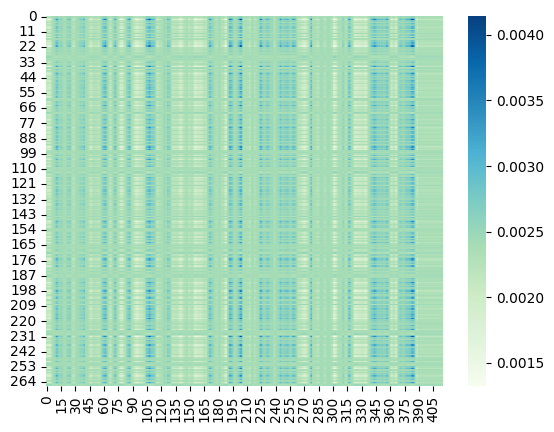

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best model

Epoch: 2/20


Learning Rate 0.0010000
	Train Loss 1.4956	 Running_perplexity 4.4731
	Val Dist 476.3351


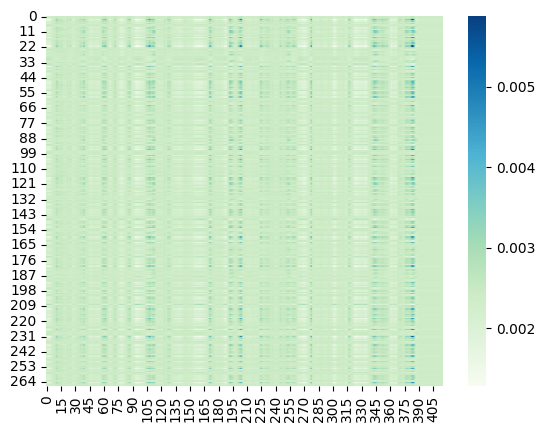

Saved best model

Epoch: 3/20


Learning Rate 0.0010000
	Train Loss 1.3803	 Running_perplexity 3.9816
	Val Dist 480.0282


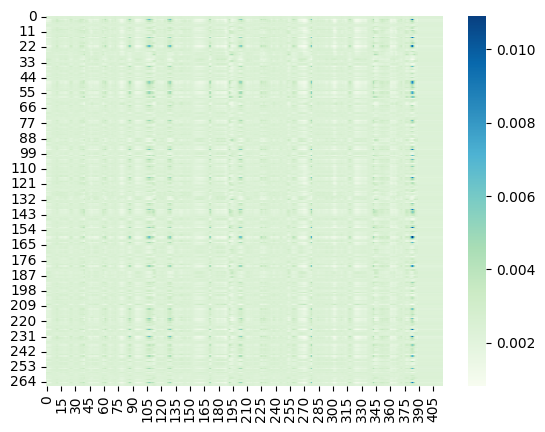


Epoch: 4/20


Learning Rate 0.0010000
	Train Loss 1.3182	 Running_perplexity 3.7412
	Val Dist 479.7961


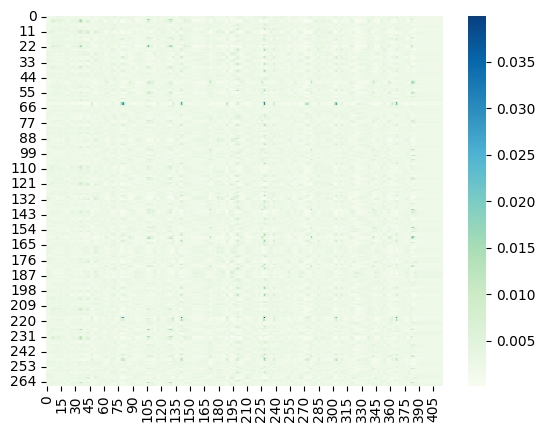


Epoch: 5/20


Learning Rate 0.0010000
	Train Loss 1.2710	 Running_perplexity 3.5686
	Val Dist 482.0249


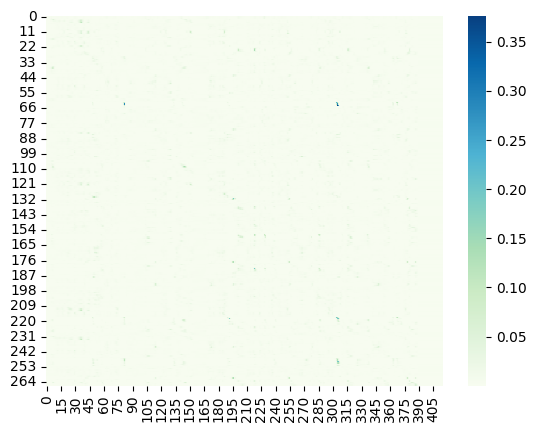


Epoch: 6/20


Learning Rate 0.0010000
	Train Loss 1.1052	 Running_perplexity 3.0490
	Val Dist 234.8004


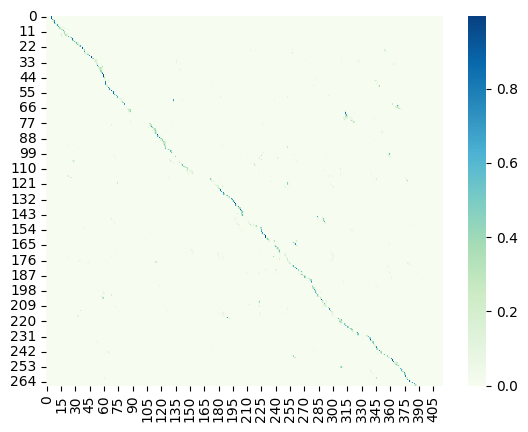

Saved best model

Epoch: 7/20


Train:  70%|██████▉   | 155/223 [05:48<02:33,  2.26s/it, loss=0.5782, lr=0.0010, perplexity=1.7949, tf_rate=1.00]

In [ ]:
best_lev_dist = float("inf")
tf_rate = 1.0

for epoch in range(0, config['epochs']):
    
    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))
    curr_lr = float(optimizer.param_groups[0]['lr']) 

    # Call train and validate, get attention weights from training
    # if epoch < 8:
    #     tf_rate = 1.0
    # elif epoch < 15:
    #     tf_rate = 0.95
    # else:
    #     tf_rate -= 0.01

    train_loss, running_perplexity, attention_plot =  train(model, train_loader, criterion, optimizer, teacher_forcing_ratio = tf_rate) #TODO
   
    valid_dist  = validate(model, dev_loader) #TODO
    scheduler.step(valid_dist)

    # Print your metrics
    print("Learning Rate {:.07f}".format(curr_lr))
    print("\tTrain Loss {:.04f}\t Running_perplexity {:.04f}".format(train_loss, running_perplexity))
    print("\tVal Dist {:.04f}".format(valid_dist))

    # Plot Attention for a single item in the batch
    plot_attention(attention_plot[0].cpu().detach().numpy().squeeze(1))
    np.save('/content/model/weight.txt',attention_plot[0].cpu().detach().numpy().squeeze(1))

    # Log metrics to Wandb
    wandb.log({
        'train_loss': train_loss,  
        'valid_dist': valid_dist, 
        'lr'        : curr_lr
    })

    # Optional: Scheduler Step / Teacher Force Schedule Step


    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        # Save your model checkpoint here
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        wandb.save(best_model_path)
        print("Saved best model")

run.finish()

# Testing

In [ ]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle